## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [6]:
# Read in dataset
df = pd.read_csv('ab_data.csv')
df.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


b. Use the cell below to find the number of rows in the dataset.

In [7]:
# Shape of our dataset
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [8]:
# Find unique user IDs
df.user_id.nunique()

290584




d. The proportion of users converted.

In [9]:
# Find average converted users
sum(df['converted'] == True) / len(df['converted'])

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [10]:
# Find number of time new_page != treatment and treatment != new_page
len(df.query("landing_page == 'new_page' and group != 'treatment'")) 
+ len(df.query("landing_page != 'new_page' and group == 'treatment'"))

1965

f. Do any of the rows have missing values?

In [11]:
# Find if there is any null 
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [12]:
# Append 2 queries exclusing mismatches
df_q1 = df.query("group == 'treatment' and landing_page == 'new_page'") 
df_q2 = df.query("group == 'control' and landing_page == 'old_page'") 
df2 = df_q1.append(df_q2)
df2.shape

(290585, 5)

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [14]:
# Number of unique user IDs
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
# Show dplicated user ID
df2[df2.user_id.duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [16]:
# Row information for duplicated user ID
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
# Drop repeated user ID and check
df2.user_id.drop_duplicates(inplace=True)
df2.user_id.duplicated().any()

False

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
# Average of converted
df2.converted.mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
# Average of people who convered in the control group
df2[df2['group'] == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
# Average of people who convered in the treatment group
df2[df2['group'] == 'treatment'].converted.mean()

0.11880724790277405

d. What is the probability that an individual received the new page?

In [21]:
# Probability of receiving the new page
len(df2[df2['landing_page'] == 'new_page'])/len(df2)

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There's a 50% chance the user will land on either pages. The chances of the user converting in both pages is the same with a slightly higher percentage of 0.16% for the old page**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


**We can descibe our null hypotheses to be that the average of people converting using the old $p_{old}$ page is greater than the new page $p_{new}$. The alternative hypotheses is the average of people converting in the new page $p_{new}$ is equal or less to old page.**
<br><br>
 

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
# Conversion rate regardless of page for p new
p_new = df2['converted'].mean()
p_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
# Conversion rate regardless of page for p old
p_old = df2['converted'].mean()
p_old

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
# Number of people in the treatment group 
n_new = sum(df2.group.values == 'treatment')
n_new

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
# Number of people in the control group 
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# Simulation of conversions for new page
new_page_converted = np.random.choice([0,1], n_new, p = ((1-p_new),p_new))

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# Simulation of conversions for old page
old_page_converted = np.random.choice([0,1], n_old, p = ((1-p_old),p_old))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
# Difference of simulation
new_page_converted.mean() - old_page_converted.mean()

0.00040300976715466896

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [36]:
p_diffs = []
# Sample size same length as ab_data.csv as stated in the question
df_size = len(df)

for i in range(10000):

    samp = df2.sample(df_size,replace = True)   
    
    # Repeat process used in previous parts
    p_both = samp['converted'].mean()
    n_old = samp.query("group == 'control'").shape[0]
    n_new = samp.query("group == 'treatment'").shape[0]
    
    new_page_converted = np.random.choice([0,1], n_new, p = ((1-p_both),p_both))
    old_page_converted = np.random.choice([0,1], n_old, p = ((1-p_both),p_both))
    
    # Differance of means
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

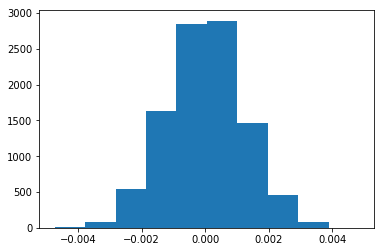

In [37]:
# Plot sampling distribution of p_diffs
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [ ]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
df2_mean = df2[df2['group'] == 'treatment'].converted.mean() - df2[df2['group'] == 'control'].converted.mean()

# Plot null distribution
plt.hist(null_vals);
# where our original df2 mean falls on null distribution
plt.axvline(df2_mean, color = 'red'); 

In [39]:
# Compute p-value
pval = (null_vals > df2_mean).mean()
pval

0.90080000000000005

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We calculated the probability of observing our statistic given the null hypothesis is true, or what we call the p-value.**
**Result: We fail to reject the null. The p-value we obtained is greater than type I error rate of 5%. The probability of users converting from the old page is greater than the new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [24]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [25]:
conv = np.array([convert_new,convert_old])
ns = np.array([n_new,n_old])

stat, pval = sm.stats.proportions_ztest(conv, ns)
print('z-score: {}'.format(stat))
print('p value: {}'.format(pval))

z-score: -1.3116075339133115
p value: 0.18965258971881804


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**This means the same as part j and k, our z-score here is in the same area displayed in our previous plot and the p-value is below 5%. We still fail to reject the null.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression, because we want to predict one of two possible outcomes: conversion or no conversion.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [22]:
import statsmodels.api as sm

df2['intercept'] = 1

# Create dummies for old and new page
page_dum = pd.get_dummies(df2['landing_page'])
df2= df2.join(page_dum)

# Drop the basaline by only creating dummy for the treatment group
df2['ab_page'] = pd.get_dummies(df['group']) ['treatment']

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [23]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [24]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Sun, 10 May 2020   Pseudo R-squ.:               8.085e-06
Time:                        14:02:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.190. It's different from before; in part II we calculated the p-value under the null assuming that the old page is better. Here we're measuring how much our values are statistically significant in relating to our responce.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It's a good idea to consider other factors to measure how related they are in effecting our response. Here we can use the timestamp by idintifing at which period of time users will most likely convert for example.**
**A disadvantage to adding additional factors is that the factors can be related or dependant of each other, may give inaccurate coefficient.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [25]:
country = pd.read_csv('countries.csv')

df2_c = df2.merge(country, on ='user_id', how='left')
df2_c.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA


In [26]:
df2_c[['UK', 'US', 'CA']] = pd.get_dummies(df2_c['country'])
df2_c = df2_c.drop(df2_c['CA'])

In [28]:
df2_c['intercept'] = 1
# Indivisual factors: country and page
log_mod = sm.Logit(df2_c['converted'], df2_c[['intercept','US','UK','new_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            3
Date:                Sun, 10 May 2020   Pseudo R-squ.:               2.322e-05
Time:                        14:06:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1761
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
US             0.0099      0.013      0.743      0.458      -0.016       0.036
UK            -0.0408      0.027     -1.516      0.129      -0.093       0.012
new_page      -0.0149      0.011     -1.306      0.191      -0.037       0.007
==============================================================================
"""

In [33]:
# Interpreting our results
1/np.exp(0.0099), 1/np.exp(-0.0408), 1/np.exp(-0.0149)

(1.0151130646157189, 1.0519020483004984, 1.0416437559600236)

- **For each unit decease in US, users are 1.015 more likely to convert, holding all other variables constant.**
- **For each unit decease in UK, users are 1.052 more likely to convert, holding all other variables constant.**
- **For each unit decease in using the new page, users are 1.042 more likely to convert, holding all other variables constant.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [38]:
df2_c['intercept'] = 1
# Interaction: product of page and country
df2_c['new_US'] = df2_c['new_page']* df2_c['US']
df2_c['new_UK'] = df2_c['new_page']* df2_c['UK']


log_mod = sm.Logit(df2_c['converted'], df2_c[['intercept','US','UK','new_page','new_US','new_UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            5
Date:                Sun, 10 May 2020   Pseudo R-squ.:               3.481e-05
Time:                        14:34:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1922
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
new_page      -0.0206      0.014     -1.504      0.132      -0.047       0.006
new_US         0.0314      0.027      1.180      0.238      -0.021       0.084
new_UK        -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

In [40]:
1/np.exp(results.params)

intercept    7.289813
US           1.005761
UK           1.017682
new_page     1.020765
new_US       0.969101
new_UK       1.048013
dtype: float64

#### Results:

- **From the p-values we can say that user's country is not statistically significant in relating to our responce variable.**
- **For each unit decrease in US, users are 1.005 more likely to convert, holding all other variables constant.**
- **For each unit decrease in UK, users are 1.017 more likely to convert, holding all other variables constant.**
- **For each unit decrease in using the new page, users are 1.02 more likely to convert, holding all other variables constant.**
- **For each unit decrease in using the new page from the US, users are 0.97 more likely to convert, holding all other variables constant.**
- **For each unit decrease in using the new page from the UK, users are 1.05 more likely to convert, holding all other variables constant.**

#### Conclusion:

- **Both country and page are not good factors in predicting rate of conversion based on resulted numbers.**
- **User country is not statistically significant in predicting conversion.**
- **Supporting our null hypothesis, users are less likely to convert using the new page, holding all other variables constant.**
- **Users from the US are more likely to convert compared to UK and CA is the lease likely to convert.**

In [42]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0